In [29]:
import pandas as pd
import os
import zipfile
import json
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

group 1 - 2089 unique hashes
group 2 - 3357 unique hashes
738 common hashes

In [48]:
group1='weight_loss'
group2='adolescent'
db ='all_chloroplast'
scale = '100'
k='21'

hash_matches_path = f"../snakemake-workflow/output/{group1}/{db}.{scale}/hash_matches"
ext = f"*{k}.query-matches.sig"


target_files = glob.glob(os.path.join(hash_matches_path,ext))
print(target_files[:5])



['../snakemake-workflow/output/weight_loss/all_chloroplast.100/hash_matches/ERR11520727.21.query-matches.sig', '../snakemake-workflow/output/weight_loss/all_chloroplast.100/hash_matches/ERR11520705.21.query-matches.sig', '../snakemake-workflow/output/weight_loss/all_chloroplast.100/hash_matches/ERR11520690.21.query-matches.sig', '../snakemake-workflow/output/weight_loss/all_chloroplast.100/hash_matches/ERR11520714.21.query-matches.sig', '../snakemake-workflow/output/weight_loss/all_chloroplast.100/hash_matches/ERR11520712.21.query-matches.sig']


In [116]:
def fetch_files(group,db,scale,k):
    hash_matches_path = f"../snakemake-workflow/output/{group}/{db}.{scale}/hash_matches/"
    ext = f"*{k}.query-matches.sig"

    target_files = glob.glob(os.path.join(hash_matches_path,ext))
    return target_files[:40]



def sig2dict(target_files):    
    data_dict ={}
    for i in range(len(target_files)):
        sample = target_files[i].split('/')[-1].split('.')[0]
        with open(target_files[i]) as f:
            js = json.loads(f.read())
        data_dict[sample] = [js[0]['signatures'][0]['mins'],js[0]['signatures'][0]['abundances']]
    return data_dict


def dict2df(data_dict):
    df = pd.DataFrame(index=data_dict.keys())
    for sample, (hashes, values) in data_dict.items():
        for hash_val, value in zip(hashes, values):
            df.loc[sample, hash_val] = value #slow and defragmented? apparently

    # Fill NaN values with 0
    return df.fillna(0)

def group_df(group,db,scale,k):
    group_files = fetch_files(group,db,scale,k)
    group_dict = sig2dict(group_files)
    group_df = dict2df(group_dict)
    group_df['group'] = group
    return group_df

def combine_groups(group1_df, group2_df):   
    combined_df = pd.concat([group1_df,group2_df], axis=0)
    combined_df = combined_df.fillna(0)
    return combined_df
    
def fit_rf(combined_df,output_dir):    
    y = combined_df['group']
    X = combined_df.drop('group',axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Build the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Display the confusion matrix using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))

    # feature importance
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'hashes': X.columns, 'importance': feature_importances})
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    importance_df.to_csv(os.path.join(output_dir, "feature_imp.csv"), index=False)
    return importance_df


In [117]:
group1='weight_loss'
group2='adolescent'
db ='all_chloroplast'
scale = '100'
k='21'
group1_df = group_df(group1,db,scale,k)
group2_df =group_df(group2,db,scale,k)

In [118]:
1/2018


0.0004955401387512388

In [119]:
combined_df = combine_groups(group1_df,group2_df)

Accuracy: 1.00
[[ 5  0]
 [ 0 11]]


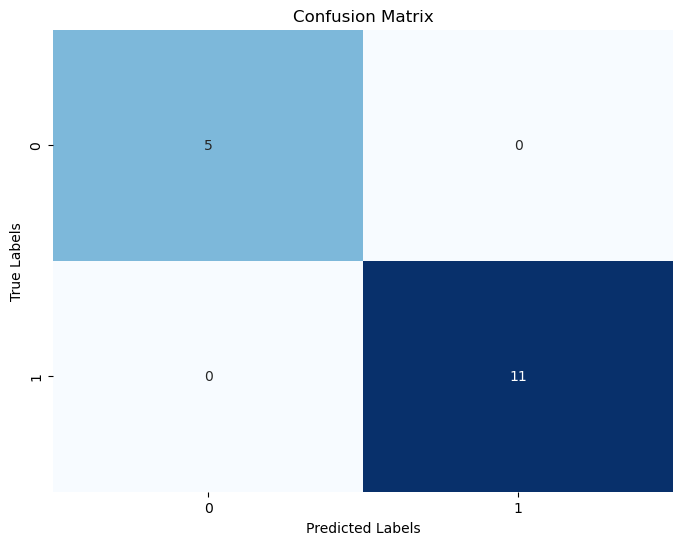

In [120]:
importance_df =fit_rf(combined_df, '../test/')

feature importance

add # samples with hash in group1/group2; avg abundance
sourmash compare containment
sourmash sig kmer
mumur hash inverse


In [121]:
group1_df.head()

,1606260579501664,1813585431686596,2995437848616634,4796196837742189,4987512135801218,5378885294124211,6636926258102079,6931303674672049,6979028009707617,7148218830226502,...,102491093163224167,107401954464595057,116852488479985123,117824902627743261,122933586759915486,130178645424869241,131052121386870670,169370378379323727,182205120279735791,group
ERR11520727,5.0,1.0,41.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,weight_loss
ERR11520705,163.0,0.0,63.0,0.0,4.0,0.0,4.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,weight_loss
ERR11520690,4017.0,0.0,41.0,0.0,3426.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,weight_loss
ERR11520714,6.0,0.0,26.0,0.0,1903.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,weight_loss
ERR11520712,6.0,0.0,58.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,weight_loss


In [122]:
non_zero_count = group1_df[67236570887032679].astype(bool).sum()
total_rows = len(group1_df)
percentage_non_zero = (non_zero_count / total_rows) * 100
print(non_zero_count,total_rows,percentage_non_zero)
print(group1_df[67236570887032679].mean())

36 40 90.0
3.875


In [129]:
def feat_imp_hashes_info(row):
    """
    Info To do
    1. percent of group1 and group2 with hash in it
    2. avg abundance of hash in group1 and group2
    3. sample in which has in present in and it's group

    """
    hash = row['hashes']
    def percentage(group_df):
        try:
            non_zero_count = group_df[hash].astype(bool).sum()
            total_rows = len(group_df)
            percentage_non_zero = (non_zero_count / total_rows) * 100
             
            group_avg_abund = group_df[hash].mean()
            return percentage_non_zero, group_avg_abund
        except KeyError:
            return (0,0)
    
    group1_percent, group1_avg_abund = percentage(group1_df)
    group2_percent, group2_avg_abund = percentage(group2_df)
    

    return (group1_percent, group2_percent, group1_avg_abund, group2_avg_abund)

    

In [124]:
feat_imp_hashes_info(67236570887032679, group1_df,group2_df)

TypeError: feat_imp_hashes_info() takes 1 positional argument but 3 were given

In [131]:
importance_df[['group1_percent','group2_percent', 'group1_avg_abund', 'group2_avg_abund' ]] = importance_df.apply(feat_imp_hashes_info, axis=1, result_type='expand')

In [134]:
importance_df[:50]

,hashes,importance,group1_percent,group2_percent,group1_avg_abund,group2_avg_abund
32,25927711859011030,0.049613,100.0,0.0,2177.050,0.000
193,4545284212519187,0.042512,95.0,0.0,129.100,0.000
150,145007500381155718,0.042030,92.5,0.0,4.125,0.000
68,67236570887032679,0.038629,90.0,2.5,3.875,0.025
170,165349534531629963,0.037580,100.0,2.5,9.375,0.025
80,75643098487055487,0.030680,95.0,37.5,7593.050,883.325
111,108817344815512168,0.026695,100.0,27.5,25.175,0.975
15,12459344525005503,0.023860,100.0,47.5,69.675,7.000
41,37862007360175795,0.022152,97.5,7.5,7.725,0.075
57,56788218875501276,0.021190,70.0,0.0,1292.000,0.000


In [ ]:
def hashes2sig(importance_df,n,name,k)
    

SyntaxError: expected ':' (1633820744.py, line 1)

In [ ]:
sig_format =[{"class":"sourmash_signature","email":"","hash_function":"0.murmur64","filename":None,
            "name":"ERR11520689-known","license":"CC0","signatures":[{"num":0,"ksize":51,"seed":42,"max_hash":184467440737095520,
            "mins":[5756550895798050,18258183296097495,33184746805409822,64575427079866475,90221529221383823,128845925818673832,130328166939714435,178750497274472558,179326412510026308],
            "md5sum":"ec34a9d81ea0b3594b5d350bca52e359","abundances":[258,105,1,1,2,5,11,1,2063],"molecule":"dna"}],"version":0.4}]

In [ ]:
sig_format[0]['signatures'][0]['mins'] = importance_df['Feature'][:50].tolist()
sig_format[0]['signatures'][0]['abundances'] = importance_df['Importance'][:50].tolist()
sig_format[0]['name']='feat_imp_test'

sig_format[0]['signatures'][0]['ksize']=21

In [ ]:
with open("../test/feature_imp.sig", "w") as json_file:
    json.dump(sig_format, json_file)


histgram of hashes